<a href="https://colab.research.google.com/github/albim72/BOOTCAMP_PYTHON_II/blob/main/autokoder_kolorowanie_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

kolorująca sieć autokodująca
dane wejściowe: obrazy monochromatyczne oraz kolorowe
Algorytm będzie zaszumiał obraz poprzez modyfikację pikseli (zmiana parametrów koloru)

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


In [5]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [7]:
def rgb2gray(rgb):
  """
  konwersja obrazu w RGB do skali szarości
  skala szarości = 0.299*R + 0.587*G + 0.114*B
  argumenty: rgb -> tensor
  zwraca: obraz w skali szarości
  """
  return np.dot(rgb[...,:3],[0.299,0.587,0.114])

In [8]:
(x_train, _),(x_test, _) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [12]:
#wprowadzenie wymiarów obrazu
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [13]:
#utworzenie folderu zapisane_obrazy
imgs_dir = 'zapisane_obrazy'
save_dir = os.path.join(os.getcwd(),imgs_dir)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

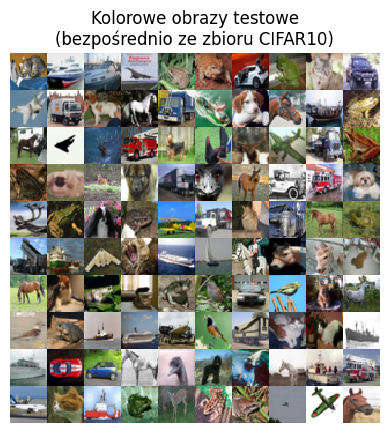

In [14]:
#wyświetlenie pierwszych 100 obrazów wejściowych (kolorowe i monochromia)
imgs = x_test[:100]
imgs = imgs.reshape((10,10,img_rows,img_cols,channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Kolorowe obrazy testowe\n(bezpośrednio ze zbioru CIFAR10)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.savefig('%s/test_color.tif' % imgs_dir)
plt.show()

In [15]:
#konwersja obrazów treningowych i testowych na skalę szarości
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

In [ ]:
#wyświetlenie obrazów testowych w skali szarości


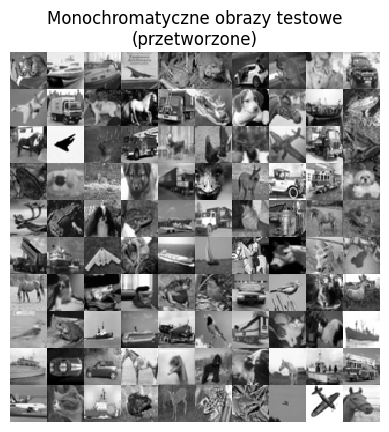

In [16]:
#wyświetlenie pierwszych 100 obrazów wejściowych (kolorowe i monochromia)
imgs = x_test_gray[:100]
imgs = imgs.reshape((10,10,img_rows,img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Monochromatyczne obrazy testowe\n(przetworzone)')
plt.imshow(imgs, interpolation='none', cmap = 'gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.savefig('%s/test_gray.tif' % imgs_dir)
plt.show()

In [17]:
#normalizacja wyjściowych obrazów zbioru treningowego i testowego w kolorze
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [18]:
#normalizacja wejściowych obrazów zbioru treningowego i testowego w skali szarości
x_train_gray = x_train_gray.astype('float32')/255
x_test_gray = x_test_gray.astype('float32')/255

In [20]:
#zmiana kształtów obrazów
x_train = x_train.reshape(x_train.shape[0],img_rows,img_cols,channels)
x_test= x_test.reshape(x_test.shape[0],img_rows,img_cols,channels)

In [21]:
#zmiana kształtów obrazów dla skali szarości
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0],img_rows,img_cols,1)
x_test_grey = x_test_gray.reshape(x_test_gray.shape[0],img_rows,img_cols,1)

In [29]:
#parametry sieci
input_shape = (img_rows,img_cols,1)
batch_size = 32
kernel_size = 3
latent_dim = 256
#liczba warstw CNN i filtrów na warstwę kodera i dekodera
layer_filters = [64,128,256]

In [30]:
#budowanie modelu autokodera
#pierwszy krok -> koder
inputs = Input(shape=input_shape, name='koder_wejście')
x = inputs
#stos warstw Conv2D(32) - Conv2D(64)
for filters in layer_filters:
  x = Conv2D(filters=filters,
             kernel_size = kernel_size,
             strides=2,
             activation='relu',
             padding='same')(x)

In [31]:
#W celu zbudowania sieci autokodującej potrzebujemy: informacje nt kształtu(shape) danych.
#Aby nie liczyć ręcznie użyjemy warstwy Transpose -> na wejściu (4,4,256),
#natąpi przekształcenie przez enkoder do kształtu (32,32,3)

shape = K.int_shape(x)
#generowanie wektora niejawnego
x = Flatten()(x)
latent = Dense(latent_dim,name='latent_vector')(x)

#tworzenie instancji modelu kodera
encoder = Model(inputs,latent,name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 koder_wejście (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        640       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

In [32]:
#budowanie modelu dekodera
latent_inputs = Input(shape=(latent_dim,),name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2], shape[3]))(x)

In [33]:
#stos warstw Transpose
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters = filters,
                      kernel_size=kernel_size,
                      strides=2,
                      activation='relu',
                      padding='same')(x)
  outputs = Conv2DTranspose(filters = channels,
                      kernel_size=kernel_size,
                      activation='sigmoid',
                      padding='same',
                      name='decoder_output')(x)

In [34]:
#utworzenie instancji modelu dekodera
decoder = Model(latent_inputs,outputs,name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)       7379

In [35]:
#sieć autodująca -> enkoder + dekoder
#utworzenie instancji sieci autokodującej
autoencoder = Model(inputs,decoder(encoder(inputs)),name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 koder_wejście (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________
